## 1. Modeling and System Identification

### 1.1. Basic Knowledge

Nominal Transfer Functions

$G_{\theta , 0} = \dfrac{1547.4}{(s^2 + 10.12s + 390.4)(s + 5.373)}$

$G_{\phi , 0} = \dfrac{2049.5}{(s^2 + 19.03s + 426.2)(s + 6.764)}$

<br>

Unstructured Uncertainty -> Multiplicative Perturbation

$W_{\theta}(s) = \dfrac{1659.6(s^2 + 2.868s + 60.44)}{(s + 9.678)(s + 24770)}$

$W_{\phi}(s) = \dfrac{1.9017(s^2 + 3.813s + 91.61)}{(s^2 + 43.53s + 545.3)}$

#### Why Not MIMO?

Practical Constraints:
Open-loop instability made MIMO identification challenging.

Pilot difficulty during experiments (Section 2.1: "experimental data is better obtained for each channel separately").

Simplification:
The authors prioritized feasibility over theoretical MIMO rigor, noting that coupling effects were small near hover conditions.

####  Two-Stage Control Design (Casscade Architecture) -> Used for MIMO Systems, Uncertainty Reduction and Design Improvements

1. Inner Loop (Stabilization):

    A basic PID is used during system identification to stabilize the quadrotor and collect experimental data. This PID is crude but sufficient for safe hovering during data collection.
<br>

2. Outer Loop (Performance/Robustness):

    The $H_\infty$ controller is designed based on the identified closed-loop model (which includes the PID’s effects) and it augments it in a cascade architecture.
    
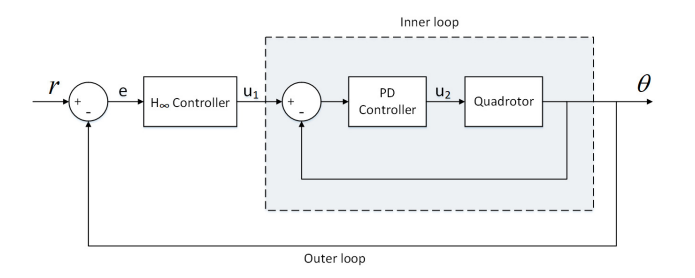

In [20]:
s = tf('s');

% Nominal Transfer functions
G_theta = 1547.4 / ((s^2 + 10.12*s + 390.4)*(s + 5.373))
G_phi = 2049.5 / ((s^2 + 19.03*s + 426.2)*(s + 6.764))

% Weighting Functions
W_theta = 1659.6*(s^2 + 2.868*s + 60.44) / ((s + 9.678)*(s + 24770))
W_phi = 1.9017*(s^2 + 3.813*s + 91.61) / (s^2 + 43.53*s + 545.3)


G_theta =
 
                1547
  --------------------------------
  s^3 + 15.49 s^2 + 444.8 s + 2098
 
Continuous-time transfer function.


G_phi =
 
                2050
  --------------------------------
  s^3 + 25.79 s^2 + 554.9 s + 2883
 
Continuous-time transfer function.


W_theta =
 
  1660 s^2 + 4760 s + 1.003e05
  ----------------------------
  s^2 + 2.478e04 s + 2.397e05
 
Continuous-time transfer function.


W_phi =
 
  1.902 s^2 + 7.251 s + 174.2
  ---------------------------
     s^2 + 43.53 s + 545.3
 
Continuous-time transfer function.



### 1.2. Modeling Uncertain SISO Systems in Matlab

In [3]:
% Create uncertain systems
delta_theta = ultidyn('delta_theta', [1 1]); % [1 1] -> SISO Approach
delta_phi = ultidyn('delta_phi', [1 1]);

% Perturbed Transfer Functions
G_theta_unc = G_theta * (1 + W_theta * delta_theta)
G_phi_unc = G_phi * (1 + W_phi * delta_phi)


G_theta_unc =

  Uncertain continuous-time state-space model with 1 outputs, 1 inputs, 5 states.
  The model uncertainty consists of the following blocks:
    delta_theta: Uncertain 1x1 LTI, peak gain = 1, 1 occurrences

Type "G_theta_unc.NominalValue" to see the nominal value, "get(G_theta_unc)" to see all properties, and "G_theta_unc.Uncertainty" to interact with the uncertain elements.


G_phi_unc =

  Uncertain continuous-time state-space model with 1 outputs, 1 inputs, 5 states.
  The model uncertainty consists of the following blocks:
    delta_phi: Uncertain 1x1 LTI, peak gain = 1, 1 occurrences

Type "G_phi_unc.NominalValue" to see the nominal value, "get(G_phi_unc)" to see all properties, and "G_phi_unc.Uncertainty" to interact with the uncertain elements.



### 1.3. Uncertainty Visualization

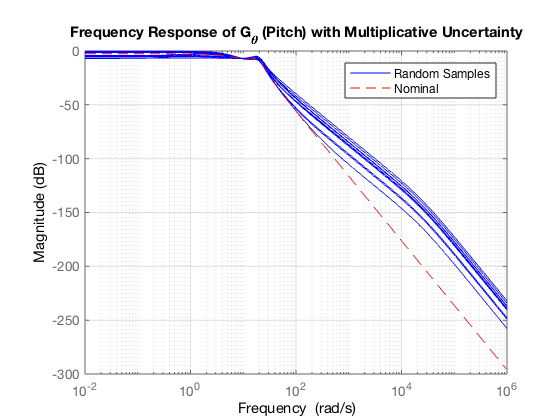

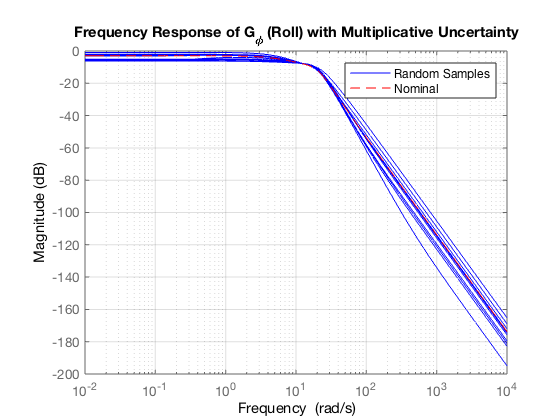

In [4]:
% Generate custom number of samples (The default number is 20)
num_samples = 10;
G_theta_samples = usample(G_theta_unc, num_samples);
G_phi_samples = usample(G_phi_unc, num_samples);

% Bode Plots of both Nominal and Uncertain Systems
figure;
bodemag(G_theta_samples, 'b', G_theta, 'r--');
title('Frequency Response of G_{\theta} (Pitch) with Multiplicative Uncertainty');
legend('Random Samples', 'Nominal');
grid on;

figure;
bodemag(G_phi_samples, 'b', G_phi, 'r--');
title('Frequency Response of G_{\phi} (Roll) with Multiplicative Uncertainty');
legend('Random Samples', 'Nominal');
grid on;

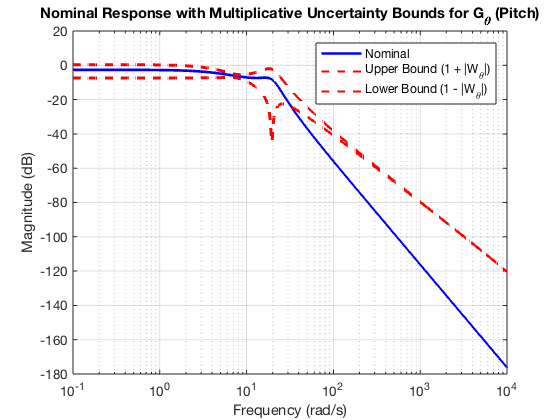

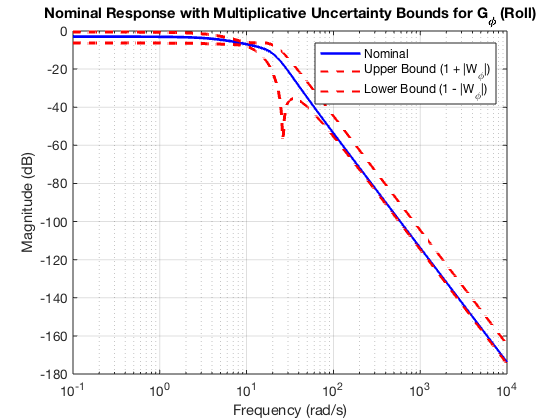

In [5]:
omega = logspace(-1, 4, 500);

% Frequency Responses
[mag_theta, phase_theta] = bode(G_theta, omega);
mag_theta = squeeze(mag_theta); % Remove singleton dimensions

[mag_W_theta, ~] = bode(W_theta, omega);
mag_W_theta = squeeze(mag_W_theta);

[mag_phi, phase_phi] = bode(G_phi, omega);
mag_phi = squeeze(mag_phi);

[mag_W_phi, ~] = bode(W_phi, omega);
mag_W_phi = squeeze(mag_W_phi);

% Uncertainty Bounds
upper_theta = mag_theta .* (1 + mag_W_theta);
lower_theta = mag_theta .* (1 - mag_W_theta);

upper_phi = mag_phi .* (1 + mag_W_phi);
lower_phi = mag_phi .* (1 - mag_W_phi);

% Plotting
figure;

% --- Pitch (G_theta) ---
semilogx(omega, 20*log10(mag_theta), 'b', 'LineWidth', 2); hold on;
semilogx(omega, 20*log10(upper_theta), 'r--', 'LineWidth', 1.5);
semilogx(omega, 20*log10(lower_theta), 'r--', 'LineWidth', 1.5);
title('Nominal Response with Multiplicative Uncertainty Bounds for G_\theta (Pitch)');
xlabel('Frequency (rad/s)');
ylabel('Magnitude (dB)');
legend('Nominal', 'Upper Bound (1 + |W_\theta|)', 'Lower Bound (1 - |W_\theta|)');
grid on;

% --- Roll (G_phi) ---
figure;
semilogx(omega, 20*log10(mag_phi), 'b', 'LineWidth', 2); hold on;
semilogx(omega, 20*log10(upper_phi), 'r--', 'LineWidth', 1.5);
semilogx(omega, 20*log10(lower_phi), 'r--', 'LineWidth', 1.5);
title('Nominal Response with Multiplicative Uncertainty Bounds for G_\phi (Roll)');
xlabel('Frequency (rad/s)');
ylabel('Magnitude (dB)');
legend('Nominal', 'Upper Bound (1 + |W_\phi|)', 'Lower Bound (1 - |W_\phi|)');
grid on;

### 1.4. Objectives and Pre-requirements

Settling Time $\approx 0.3 s$

Overshoot $\approx 0$

Steady State Error $\approx 0$

Control Effort Limitations (Avoiding Actuator Saturation)

## 2. Robust H∞ Control Synthesis

### 2.1. Claculations of Weighting Functions

#### A) Sensivity Weighting Function</b>

Assumption: Second Order Closed-Loop System

Closed-Loop Transfer Function (Ideal Function):

$T_{cl}(s) = \dfrac{\omega_n^2}{s^2 + 2\zeta\omega_ns + \omega_n^2}$

Peak Overshoot: (Step Input)

$M_p = exp(-\dfrac{\pi\zeta}{\sqrt{1 - \zeta^2}}) \approx 10^{-6}$

$\zeta = \dfrac{-ln(M_p)}{\sqrt{\pi^2 + (ln(M_p))^2}}$

Settling Time:

$t_s \approx \dfrac{4}{\zeta\omega_n} \approx 0.3s$

Solving peak overshoot criterion leads to:

In [6]:
Mp_desired = 1e-6; % Desired overshoot (e.g., 0.0001%)
zeta_solved = (-log(Mp_desired)) / sqrt(pi^2 + (log(Mp_desired))^2);
disp(['Required Damping Ratio: ', num2str(zeta_solved)]);

Required Damping Ratio: 0.97511


Also the natural frequency is obtained from settling time formula:

$t_s \approx \dfrac{4}{\zeta\omega_n} \approx 0.3s \Rightarrow \omega_n = \dfrac{4}{0.3\zeta} = 13.61 rad.s^{-1}$

In the next step, the ideal closed-loop transfer function is calculated:

$T_{id}(s) = \dfrac{\omega_n^2}{s^2 + 2\zeta\omega_ns + \omega_n^2} = \dfrac{185.23}{s^2 + 26.68s + 185.23}$

Finally the sensivity weighting function is as follows:

$W_s = a\dfrac{1}{S_{id}(s)} = a\dfrac{1}{1 - T_{id}(s)} = a\dfrac{s^2 + 26.68s + 185.23}{s(s + 26.68)}$

In order to be strictly proper and stable:

$W_s = a\dfrac{s^2 + 26.68s + 185.23}{(s + 0.001)(s + 26.68)(s + 1000)}$

#### B) Control Effort Weighting Function

$\lVert W_uU \lVert_\infty \leq 1; \lVert U \lVert_\infty \leq 20$

$\Rightarrow W_u = 0.05$

First Trial $\Rightarrow W_u = 1$

In [7]:
% Initial Weights
W_u = 1;
a = 1;
W_s = a * (s^2 + 26.68*s + 185.23) / ((s + 0.001)*(s + 26.68)*(s + 1000));

% Build Generalized Plants
G_theta_p = augw(G_theta , W_s , W_u , W_theta);
G_phi_p = augw(G_phi , W_s , W_u , W_phi);

### 2.2. H∞ Control Synthesis (Riccati Method)

In [8]:
% Synthesize H∞ Controller
[C_theta , CL1 , gamma1 , info1] = hinfsyn(G_theta_p , 1 , 1 , 'method' , 'ric' , 'Display' , 'on');
[C_phi , CL2 , gamma2 , info2] = hinfsyn(G_phi_p , 1 , 1 , 'method' , 'ric' , 'Display' , 'on');


  Test bounds:  1.39 <=  gamma  <=  1.79

   gamma        X>=0        Y>=0       rho(XY)<1    p/f
  1.58e+00     1.3e-05     0.0e+00     1.208e-18     p
  1.48e+00     1.3e-05     0.0e+00     7.284e-17     p
  1.44e+00     1.3e-05     0.0e+00     1.020e-16     p
  1.41e+00     1.3e-05     0.0e+00     4.871e-17     p
  1.40e+00     1.3e-05     0.0e+00     9.412e-17     p

  Best performance (actual): 1.4

  Test bounds:  1.41 <=  gamma  <=  1.82

   gamma        X>=0        Y>=0       rho(XY)<1    p/f
  1.60e+00     1.3e-05     0.0e+00     2.054e-16     p
  1.50e+00     1.3e-05     0.0e+00     3.962e-19     p
  1.46e+00     1.3e-05     0.0e+00     1.922e-14     p
  1.43e+00     1.3e-05     0.0e+00     6.784e-16     p
  1.42e+00     1.3e-05     0.0e+00     6.733e-18     p

  Best performance (actual): 1.42


### 2.3. Nominal Performance Analysis

#### A) Closed-Loop Response to Step Input

The figures show that the nominal system doesn't reach the final value of the unit step input. It can also be seen that the system response is too slow and the actuator saturation occurs.

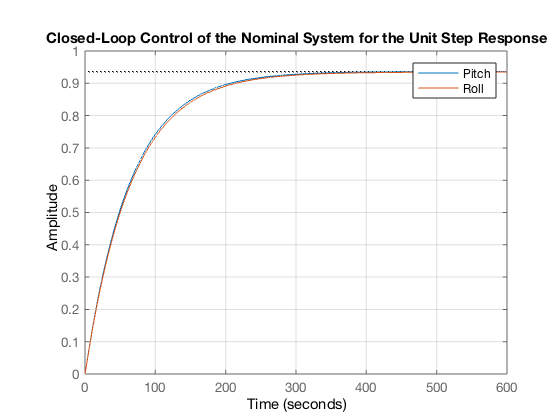

In [9]:
T_theta = feedback(G_theta*C_theta, 1); % Unity feedback
T_phi = feedback(G_phi*C_phi, 1);

% Plot Step Response
hold on;
step(T_theta);
step(T_phi);
title('Closed-Loop Control of the Nominal System for the Unit Step Response');
legend('Pitch' , 'Roll');
grid on;

#### B) Corresponding Control Effort

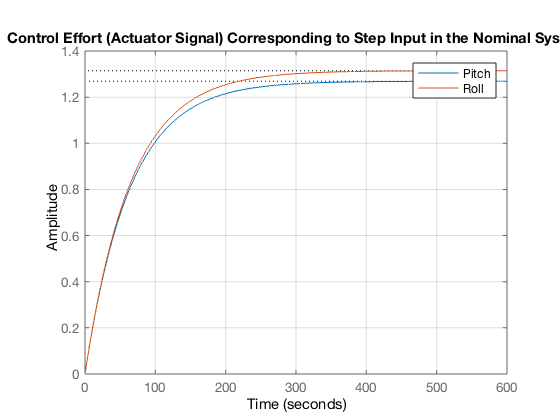

In [10]:
U_theta = C_theta / (1 + G_theta * C_theta); % Equivalent to feedback(K, G)
U_phi = C_phi / (1 + G_phi * C_phi); 

% Plot Step Response
hold on;
step(U_theta);
step(U_phi);
title('Control Effort (Actuator Signal) Corresponding to Step Input in the Nominal System');
legend('Pitch' , 'Roll');
grid on;

#### C) Singular Values and Bode Plots

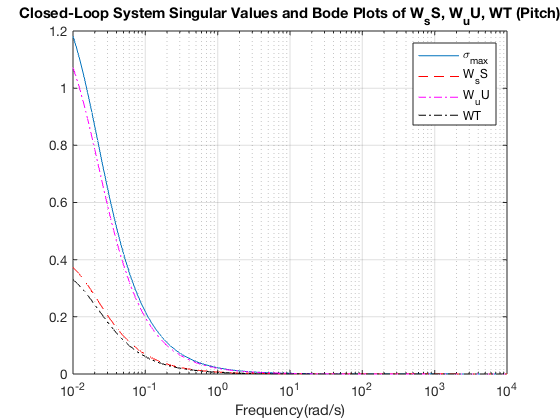

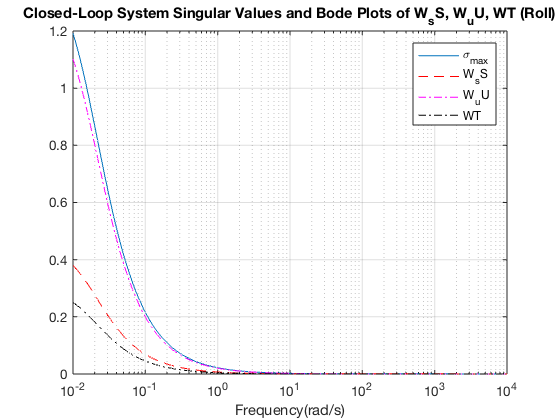

In [11]:
omega  = logspace(-2,4,300);

figure;
[mag_g1,phase_g1]=bode(CL1,omega);
sig_g1=sigma(CL1,omega);
semilogx(omega,sig_g1,omega,mag_g1(1,:),'--r',omega,mag_g1(2,:),'-.m',...
omega,mag_g1(3,:),'-.k');
title("Closed-Loop System Singular Values and Bode Plots of W_sS, W_uU, WT (Pitch)");
xlabel("Frequency(rad/s)");
legend('\sigma_{max}','W_sS','W_uU','WT');
grid on;

figure;
[mag_g2,phase_g2]=bode(CL2,omega);
sig_g2=sigma(CL2,omega);
semilogx(omega,sig_g2,omega,mag_g2(1,:),'--r',omega,mag_g2(2,:),'-.m',...
omega,mag_g2(3,:),'-.k');
title("Closed-Loop System Singular Values and Bode Plots of W_sS, W_uU, WT (Roll)");
xlabel("Frequency(rad/s)");
legend('\sigma_{max}','W_sS','W_uU','WT');
grid on;

### 2.4. Improvement Cycle (Pitch)
<b> Trial 2: </b> Increase coefficient of <b>a</b> in $W_s$ to decrease settling time

It can be seen that the system response is faster and the max singular value is getting flatter.


  Test bounds:  1.42 <=  gamma  <=  2

   gamma        X>=0        Y>=0       rho(XY)<1    p/f
  1.68e+00     4.5e-05     0.0e+00     4.359e-18     p
  1.54e+00     4.5e-05     0.0e+00     2.604e-16     p
  1.48e+00     4.5e-05     0.0e+00     7.971e-17     p
  1.45e+00     4.5e-05     0.0e+00     6.079e-18     p
  1.43e+00     4.5e-05     0.0e+00     9.899e-18     p
  1.43e+00     4.5e-05     0.0e+00     4.704e-18     p

  Best performance (actual): 1.43


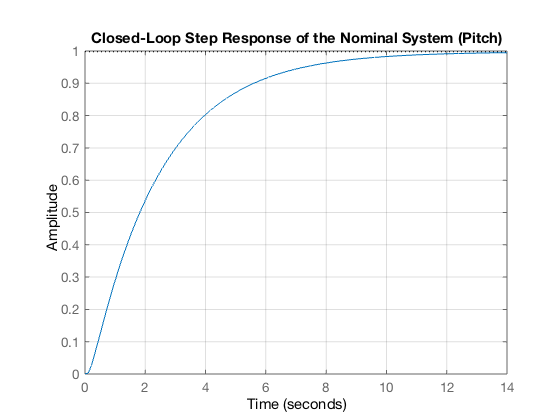

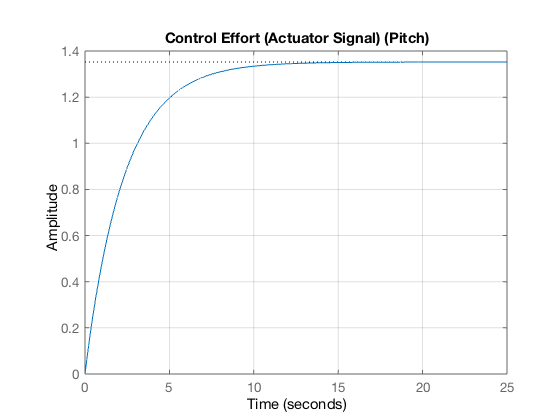

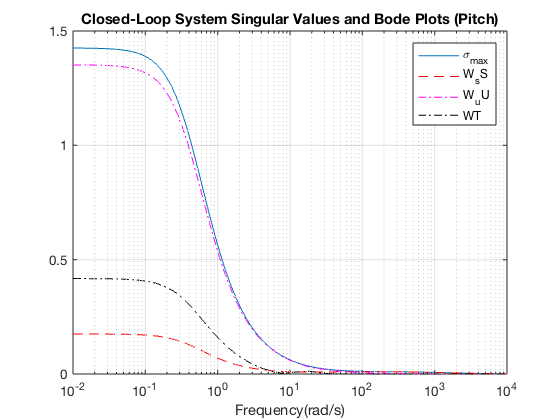

In [12]:
% Modified Weights
W_u = 1;
a = 10;
W_s = a * (s^2 + 26.68*s + 185.23) / ((s + 0.001)*(s + 26.68)*(s + 1000));

% Build Generalized Plant
G_theta_p = augw(G_theta , W_s , W_u , W_theta);

% Synthesize H∞ Controller
[C_theta , CL , gamma , info] = hinfsyn(G_theta_p , 1 , 1 , 'method' , 'ric' , 'Display' , 'on');

T = feedback(G_theta*C_theta, 1);
U = C_theta / (1 + G_theta * C_theta);

figure;
step(T);
title('Closed-Loop Step Response of the Nominal System (Pitch)');
grid on;

figure;
step(U);
title('Control Effort (Actuator Signal) (Pitch)');
grid on

figure;
omega  = logspace(-2,4,300);
[mag_g,phase_g]=bode(CL,omega);
sig_g=sigma(CL,omega);
semilogx(omega,sig_g,omega,mag_g(1,:),'--r',omega,mag_g(2,:),'-.m',...
omega,mag_g(3,:),'-.k');
title("Closed-Loop System Singular Values and Bode Plots (Pitch)");
xlabel("Frequency(rad/s)");
legend('\sigma_{max}','W_sS','W_uU','WT');
grid on;

<b>Trial 3 -> Iterative:</b> Increasing coefficient <b>a</b> and decreasing $W_u$ to release limitation on control effort.  $W_u$ is fixed with the minimum value and a loop is applied on a to reach the settling time of 0.3 seconds and insignificant overshoot.

In [13]:
% Modified Weights
W_u = 0.05;

a = 0;
settling_time = 100;
while settling_time > 0.35
    W_s = a * (s^2 + 26.68*s + 185.23) / ((s + 0.001)*(s + 26.68)*(s + 1000));

    % Build Generalized Plant
    G_theta_p = augw(G_theta , W_s , W_u , W_theta);

    % Synthesize H∞ Controller
    [C_theta , CL , gamma , info] = hinfsyn(G_theta_p , 1 , 1 , 'method' , 'ric' , 'Display' , 'on');

    T = feedback(G_theta*C_theta, 1);    
    settling_time = stepinfo(T).SettlingTime
    a = a + 50
end
disp("Iteration Completed.")


  Test bounds:  0 <=  gamma  <=  2e-06

   gamma        X>=0        Y>=0       rho(XY)<1    p/f
  2.00e-07     5.4e-06     0.0e+00     1.410e-12     p

  Best performance (actual): 2.46e-29

settling_time =

    2.0803


a =

    50


  Test bounds:  0.424 <=  gamma  <=  0.602

   gamma        X>=0        Y>=0       rho(XY)<1    p/f
  5.05e-01     6.2e-06     0.0e+00     5.469e-17     p
  4.63e-01     6.2e-06     0.0e+00     1.525e-15     p
  4.43e-01     6.2e-06     0.0e+00     1.113e-17     p
  4.33e-01     6.2e-06     0.0e+00     1.172e-15     p
  4.29e-01     6.2e-06     0.0e+00     2.458e-19     p
  4.26e-01     6.2e-06     0.0e+00     4.355e-16     p

  Best performance (actual): 0.426

settling_time =

    1.8228


a =

   100


  Test bounds:  0.424 <=  gamma  <=  0.616

   gamma        X>=0        Y>=0       rho(XY)<1    p/f
  5.11e-01     8.4e-06     0.0e+00     1.047e-19     p
  4.65e-01     8.4e-06     0.0e+00     9.874e-18     p
  4.44e-01     8.4e-06     0.0e+00     3.49

  8.78e-01    -8.1e+03 #  -6.5e-17     9.017e-16     f
  9.28e-01     3.3e-05     0.0e+00     3.141e-17     p
  9.03e-01     3.4e-05     0.0e+00     1.193e-17     p
  8.90e-01     3.4e-05     0.0e+00     6.389e-17     p
  8.84e-01    -9.6e+05 #  -1.0e-21     1.868e-15     f

  Best performance (actual): 0.89

settling_time =

    0.3477


a =

   850

Iteration Completed.



  Test bounds:  0.834 <=  gamma  <=  1.28

   gamma        X>=0        Y>=0       rho(XY)<1    p/f
  1.03e+00     3.3e-05     0.0e+00     3.194e-17     p
  9.28e-01    -1.5e+04 #  -1.9e-14     1.330e-14     f
  9.79e-01     3.3e-05     0.0e+00     1.133e-17     p
  9.53e-01     3.4e-05     0.0e+00     6.035e-17     p
  9.40e-01     3.4e-05     0.0e+00     3.826e-16     p
  9.34e-01     3.4e-05     0.0e+00     1.695e-16     p

  Best performance (actual): 0.934


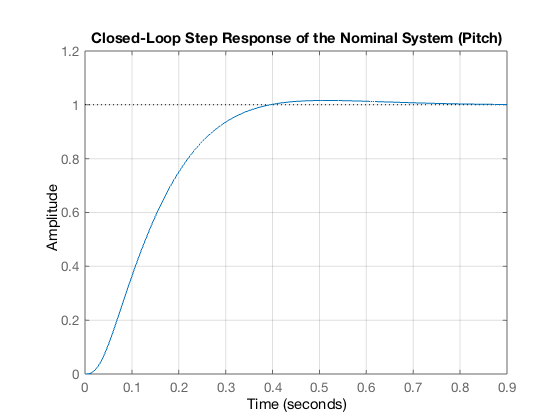

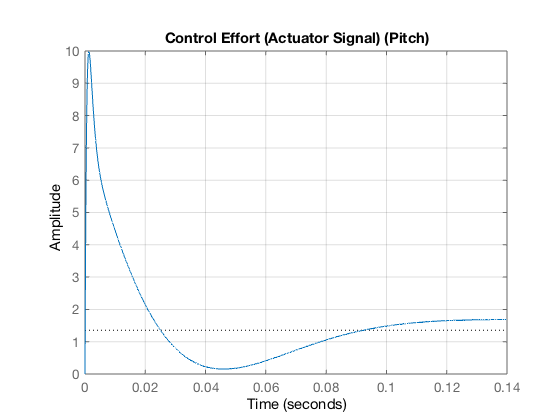

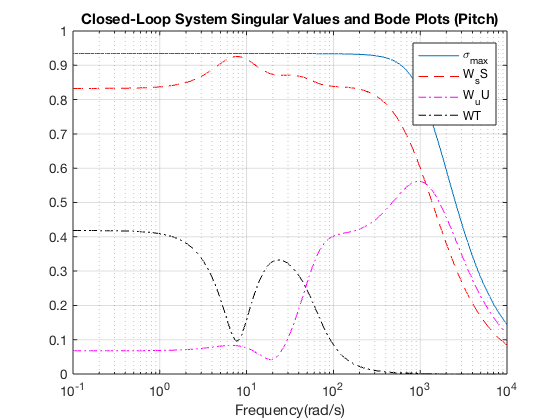

In [21]:
a = 850;
W_s = a * (s^2 + 26.68*s + 185.23) / ((s + 0.001)*(s + 26.68)*(s + 1000));
% Build Generalized Plant
G_theta_p = augw(G_theta , W_s , W_u , W_theta);

% Synthesize H∞ Controller
[C_theta , CL , gamma , info] = hinfsyn(G_theta_p , 1 , 1 , 'method' , 'ric' , 'Display' , 'on');

T = feedback(G_theta*C_theta, 1);
U = C_theta / (1 + G_theta * C_theta);

figure;
step(T);
title('Closed-Loop Step Response of the Nominal System (Pitch)');
grid on;

figure;
step(U);
title('Control Effort (Actuator Signal) (Pitch)');
grid on

figure;
omega  = logspace(-1,4,300);
[mag_g,phase_g]=bode(CL,omega);
sig_g=sigma(CL,omega);
semilogx(omega,sig_g,omega,mag_g(1,:),'--r',omega,mag_g(2,:),'-.m',...
omega,mag_g(3,:),'-.k');
title("Closed-Loop System Singular Values and Bode Plots (Pitch)");
xlabel("Frequency(rad/s)");
legend('\sigma_{max}','W_sS','W_uU','WT');
grid on;

### 2.4. Improvement Cycle (Roll)

The same steps are applied on the Roll associated objectives.

In [15]:
% Modified Weights
W_u = 0.05;

a = 0;
settling_time = 100;
while settling_time > 0.35
    W_s = a * (s^2 + 26.68*s + 185.23) / ((s + 0.001)*(s + 26.68)*(s + 1000));

    % Build Generalized Plant
    G_phi_p = augw(G_phi , W_s , W_u , W_phi);

    % Synthesize H∞ Controller
    [C_phi , CL , gamma , info] = hinfsyn(G_phi_p , 1 , 1 , 'method' , 'ric' , 'Display' , 'on');

    T = feedback(G_phi*C_phi, 1);    
    settling_time = stepinfo(T).SettlingTime
    a = a + 50
end
disp("Iteration Completed.")


  Test bounds:  0 <=  gamma  <=  2e-06

   gamma        X>=0        Y>=0       rho(XY)<1    p/f
  2.00e-07     6.3e-04     0.0e+00     3.644e-18     p

  Best performance (actual): 6.85e-30

settling_time =

    1.7988


a =

    50


  Test bounds:  0.327 <=  gamma  <=  0.473

   gamma        X>=0        Y>=0       rho(XY)<1    p/f
  3.93e-01     3.8e-04     0.0e+00     3.011e-15     p
  3.59e-01     3.9e-04     0.0e+00     2.817e-17     p
  3.43e-01     3.9e-04     0.0e+00     2.190e-16     p
  3.35e-01     3.9e-04     0.0e+00     4.301e-17     p
  3.31e-01     3.9e-04     0.0e+00     4.412e-15     p
  3.29e-01     4.0e-04     0.0e+00     2.918e-15     p

  Best performance (actual): 0.329

settling_time =

    1.1940


a =

   100


  Test bounds:  0.327 <=  gamma  <=  0.493

   gamma        X>=0        Y>=0       rho(XY)<1    p/f
  4.01e-01     6.4e-04     0.0e+00     3.923e-17     p
  3.62e-01     6.4e-04     0.0e+00     9.130e-15     p
  3.44e-01     6.4e-04     0.0e+00     1.84


  Test bounds:  0.638 <=  gamma  <=  0.968

   gamma        X>=0        Y>=0       rho(XY)<1    p/f
  7.86e-01     7.2e-04     0.0e+00     2.199e-17     p
  7.08e-01     7.4e-04     0.0e+00     1.320e-14     p
  6.72e-01    -6.1e+02 #  -1.0e-15     2.487e-15     f
  6.90e-01    -1.3e+03 #  -7.1e-17     5.423e-17     f
  6.99e-01    -2.6e+03 #  -2.6e-17     7.476e-17     f
  7.03e-01    -5.3e+03 #  -3.2e-17     5.085e-18     f
  Limiting gains...
  7.10e-01     7.4e-04     0.0e+00     1.194e-16     p
  7.10e-01     7.4e-04     0.0e+00     1.194e-16     p

  Best performance (actual): 0.71


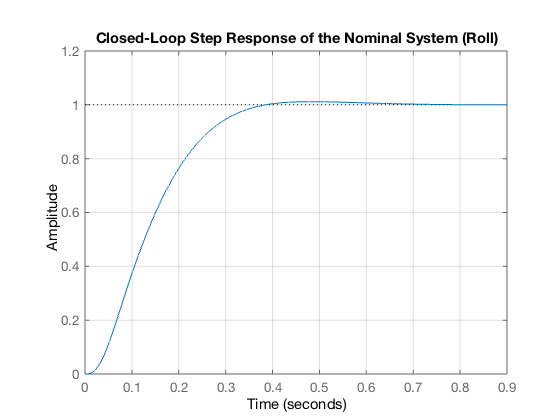

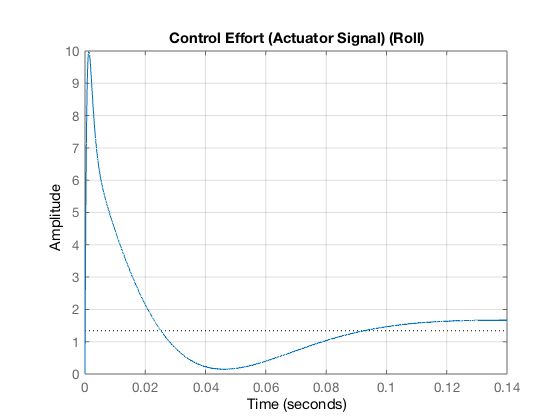

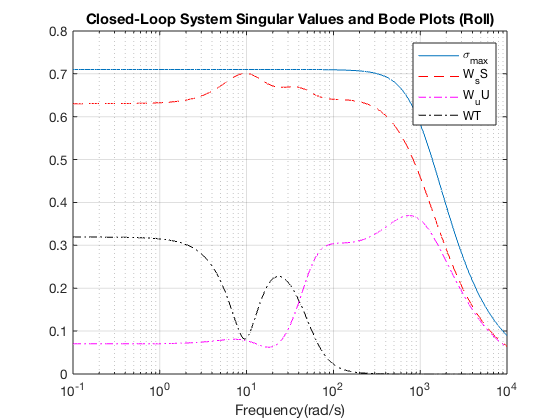

In [16]:
a = 650;
W_s = a * (s^2 + 26.68*s + 185.23) / ((s + 0.001)*(s + 26.68)*(s + 1000));
% Build Generalized Plant
G_phi_p = augw(G_phi , W_s , W_u , W_phi);

% Synthesize H∞ Controller
[C_phi , CL , gamma , info] = hinfsyn(G_phi_p , 1 , 1 , 'method' , 'ric' , 'Display' , 'on');

T = feedback(G_phi*C_phi, 1);
U = C_theta / (1 + G_phi * C_phi);

figure;
step(T);
title('Closed-Loop Step Response of the Nominal System (Roll)');
grid on;

figure;
step(U);
title('Control Effort (Actuator Signal) (Roll)');
grid on

figure;
omega  = logspace(-1,4,300);
[mag_g,phase_g]=bode(CL,omega);
sig_g=sigma(CL,omega);
semilogx(omega,sig_g,omega,mag_g(1,:),'--r',omega,mag_g(2,:),'-.m',...
omega,mag_g(3,:),'-.k');
title("Closed-Loop System Singular Values and Bode Plots (Roll)");
xlabel("Frequency(rad/s)");
legend('\sigma_{max}','W_sS','W_uU','WT');
grid on;

### 2.5. Testing on Uncertain Systems

The Optimal Robust $H_\infty$ Controllers for Pitch and Roll angles are as follows.

In [17]:
disp("Controller for Pitch Angle: ");
tf(C_theta)

disp("Controller for Roll Angle: ");
tf(C_phi)

Controller for Pitch Angle: 

ans =
 
                                                                           
  2.369e04 s^7 + 5.982e08 s^6 + 2.858e11 s^5 + 1.872e13 s^4 + 4.554e14 s^3 
                                                                           
                                    + 8.612e15 s^2 + 7.941e16 s + 2.344e17 
                                                                           
  -------------------------------------------------------------------------
                                                                          
  s^8 + 2.715e04 s^7 + 6.056e07 s^6 + 3.819e10 s^5 + 3.997e12 s^4         
                                                                          
                       + 2.165e14 s^3 + 4.539e15 s^2 + 2.44e16 s + 2.44e13
                                                                          
 
Continuous-time transfer function.

Controller for Roll Angle: 

ans =
 
                                                        

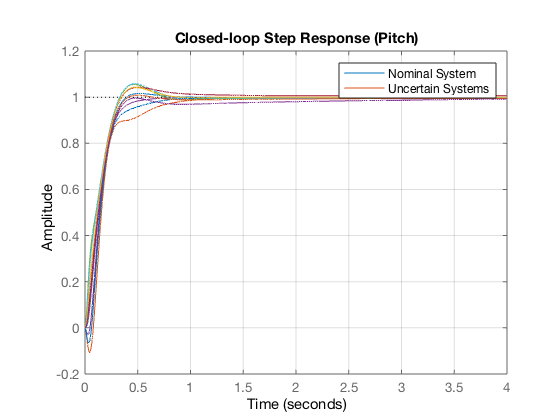

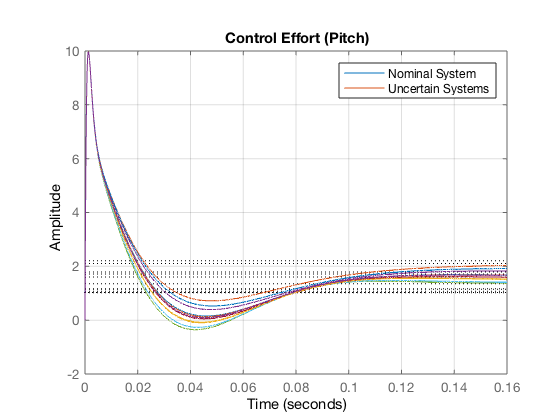

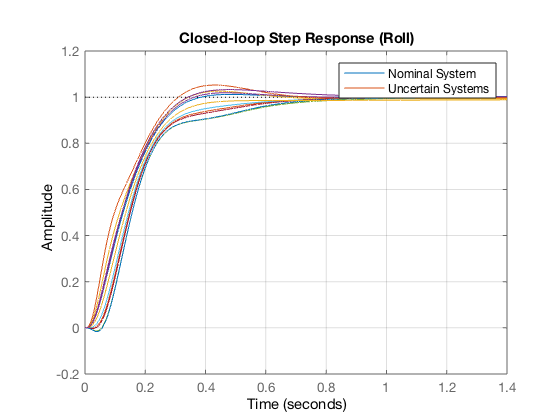

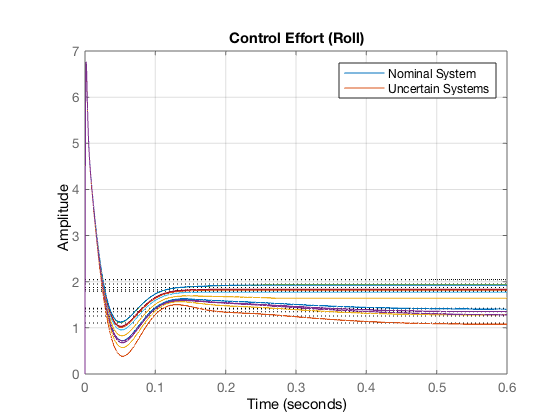

In [18]:
% Simulate step response for each sample (Pitch)
figure;
hold on;
T = feedback(G_theta*C_theta, 1);
step(T);
for i = 1:num_samples
    T = feedback(G_theta_samples(:,:,i)*C_theta, 1);  % Closed-loop
    step(T);
end
title('Closed-loop Step Response (Pitch)');
legend('Nominal System' , 'Uncertain Systems')
grid on;
hold off;

figure;
hold on;
U = C_theta / (1 + G_theta * C_theta); 
step(U);
for i = 1:num_samples
    U = C_theta / (1 + G_theta_samples(:,:,i)*C_theta);
    step(U);
end
title('Control Effort (Pitch)');
legend('Nominal System' , 'Uncertain Systems')
grid on;

% Simulate step response for each sample (Roll)
figure;
hold on;
T = feedback(G_phi*C_phi, 1);
step(T);
for i = 1:num_samples
    T = feedback(G_phi_samples(:,:,i)*C_phi, 1);
    step(T);
end
title('Closed-loop Step Response (Roll)');
legend('Nominal System' , 'Uncertain Systems')
grid on;
hold off;

figure;
hold on;
U = C_phi / (1 + G_phi * C_phi); 
step(U);
for i = 1:num_samples
    U = C_phi / (1 + G_phi_samples(:,:,i)*C_phi);
    step(U);
end
title('Control Effort (Roll)');
legend('Nominal System' , 'Uncertain Systems')
grid on;

### 2.6. Dealing with Reality: Saturation!

Actuator saturation refers to the physical limits of the actuators of the system (motors, valves, etc.). Every real-world actuator has:

Upper limit: Maximum force/voltage/speed it can provide

Lower limit: Minimum value (often zero, but could be negative for bidirectional actuators)

When the controller demands values beyond these limits, the actuator "saturates" (can't deliver more).

<b> But the fact is that the control effort under review is actually the reference input of the inner loop in the cascade architecture. Therefore, it's physically the desired angle (Pitch or Roll) and consiered to be less than 20 degrees.</b>

Simulation is done using Simulink with the presence of saturation block and the resulting curves are as follows.

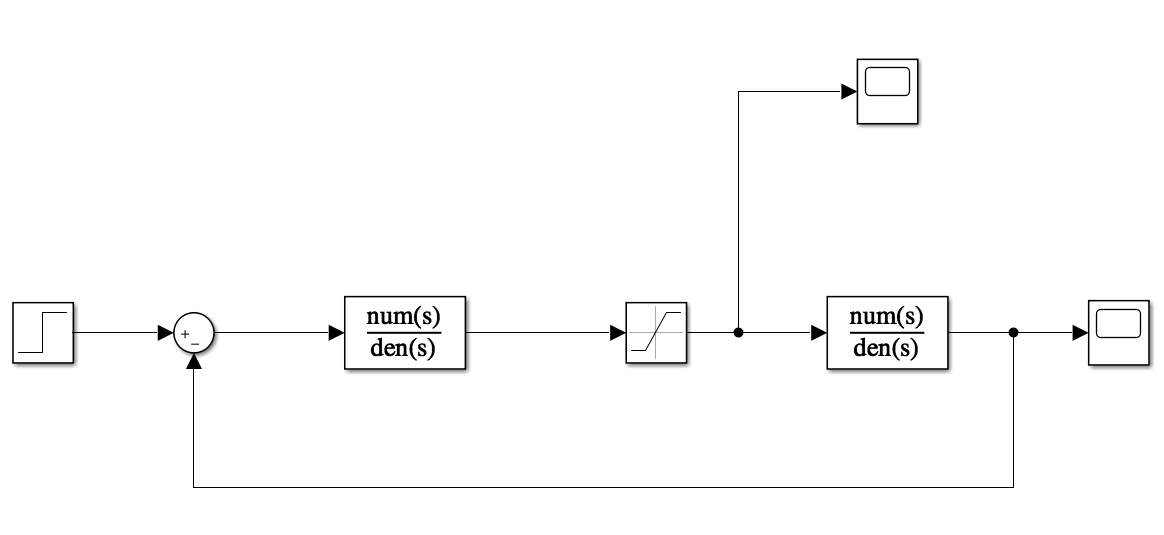

In [ ]:
load('simulink_files/workspace.mat'); % Load workspace
sim('simulink_files/saturated_pitch_system.slx'); % Run Simulink

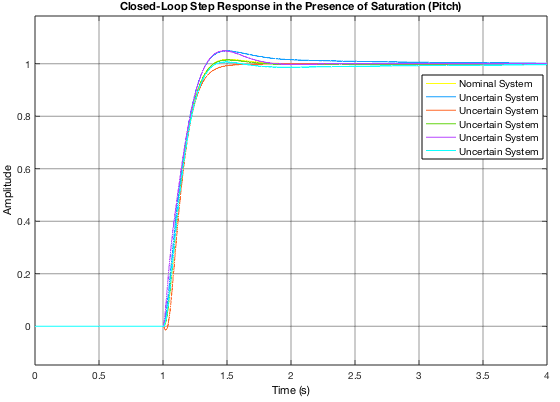

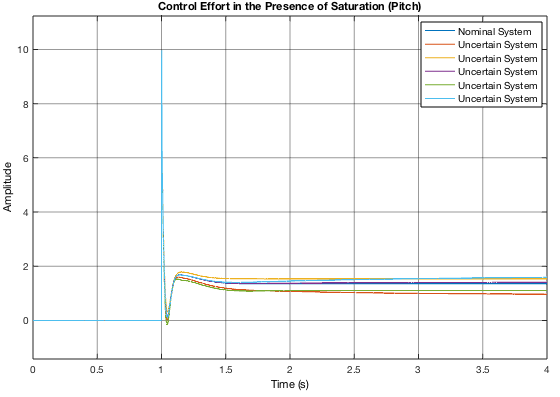

In [ ]:
sim('simulink_files/saturated_roll_system.slx');

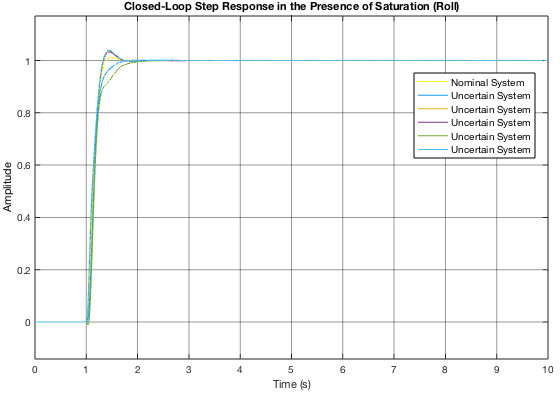

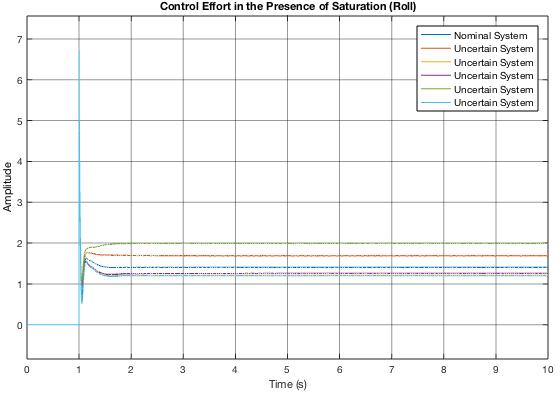

### 2.7. Testing in the Presence of Disturbance and Noise

It's essential to test the system's robustness against common disturbances and noise. Below are standard inputs used to model control effort disturbances, output disturbances, and feedback sensor noise.

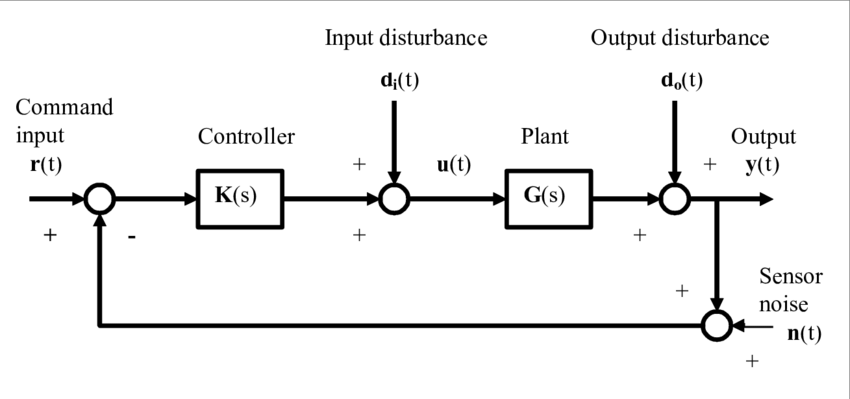

<b>Control Effort (Input) Disturbance:</b> Band-Limited White Noise with the Noise Power of 0.001

<b>Output Disturbance:</b> Pulse Input with the amplitude of 0.1 and period time of 1.5 seconds

<b>Feedback Noise:</b> The same Band-Limited White Noise to the feedback path

The disturbed systems are also saturated and simulated as shown below.

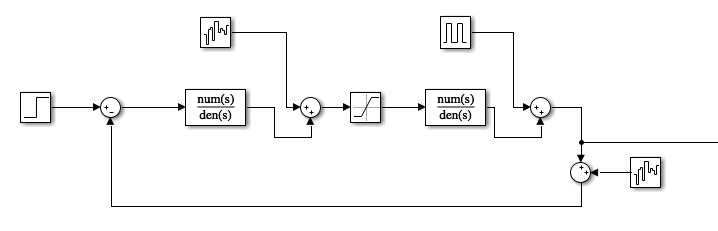

In [ ]:
sim('simulink_files/disturbed_pitch_system.slx');

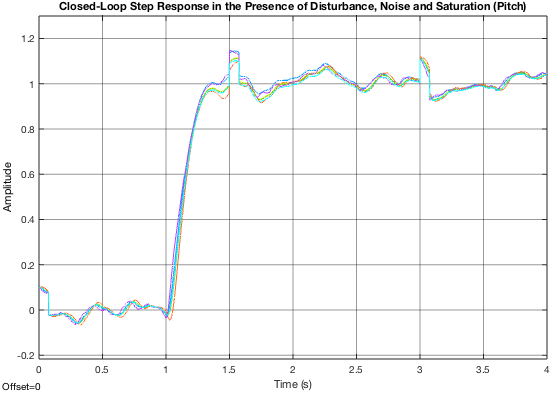

In [ ]:
sim('simulink_files/disturbed_roll_system.slx');

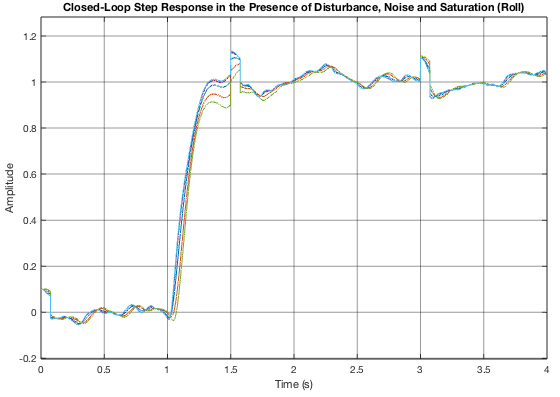

## 3.1 μ-Analysis of H∞ Controller

To determine whether the H∞ controller guarantees robust stability (RS) and robust performance (RP) against structured uncertainties.

First Building interconnection structures (cloop_theta and cloop_phi)  using 'sysic' for the uncertain models of pitch (theta) and roll (phi) axes.

We create two interconnected systems using the 'sysic' command, one for theta and one for phi, to prepare the augmented plant 

In [ ]:
P_theta   = G_theta_unc;
P_phi= G_phi_unc;

systemnames = 'P_theta C_theta W_s W_u W_theta';
inputvar = '[yd]';

input_to_C_theta   = '[yd -P_theta]';
input_to_P_theta   = '[C_theta]';
input_to_W_s  = '[yd -P_theta]';
input_to_W_u  = '[C_theta]';
input_to_W_theta   = '[P_theta]';

outputvar = '[W_s; W_u; W_theta]';
cleanupsysic = 'yes';
cloop_theta = sysic;


systemnames = 'P_phi C_phi W_s W_u W_phi';
inputvar = '[yd]';

input_to_C_phi   = '[yd -P_phi]';
input_to_P_phi   = '[C_phi]';
input_to_W_s  = '[yd -P_phi]';
input_to_W_u  = '[C_phi]';
input_to_W_phi   = '[P_phi]';

outputvar = '[W_s; W_u; W_phi]';
cleanupsysic = 'yes';
cloop_phi = sysic;

### Robustness Analysis using Mu (μ) Analysis

This step evaluates:
1. Robust Stability (RS): Ensures system remains stable under all modeled uncertainties.
2. Robust Performance (RP): Ensures both stability and performance objectives are met despite uncertainties.

In [ ]:
[stabmarg_theta, ~, ~, info_theta] = robuststab(cloop_theta);
[M_theta, ~, blkstruct_theta] = lftdata(cloop_theta);
M11_theta = M_theta(1,1);
omega_theta = info_theta.Frequency;
M11_g_theta = frd(M11_theta, omega_theta);
mu_bounds_rs_theta = mussv(M11_g_theta, blkstruct_theta, 's');

[perf_marg_theta, ~, ~, info_perf_theta] = robustperf(cloop_theta);
mu_bounds_rp_theta = info_perf_theta.MussvBnds;

figure;
semilogx(mu_bounds_rs_theta, 'b');
xlabel('Frequency (rad/sec)');
ylabel('Mu upper/lower bounds');
title('μ Plot – Robust Stability (θ)');

figure;
semilogx(mu_bounds_rp_theta, 'b');
xlabel('Frequency (rad/sec)');
ylabel('Mu upper/lower bounds');
title('μ Plot – Robust Performance (θ)');


[stabmarg_phi, ~, ~, info_phi] = robuststab(cloop_phi);
[M_phi, ~, blkstruct_phi] = lftdata(cloop_phi);
M11_phi = M_phi(1,1);
omega_phi = info_phi.Frequency;
M11_g_phi = frd(M11_phi, omega_phi);
mu_bounds_rs_phi = mussv(M11_g_phi, blkstruct_phi, 's');


[perf_marg_phi, ~, ~, info_perf_phi] = robustperf(cloop_phi);
mu_bounds_rp_phi = info_perf_phi.MussvBnds;


figure;
semilogx(mu_bounds_rs_phi, 'r');
xlabel('Frequency (rad/sec)');
ylabel('Mu upper/lower bounds');
title('μ Plot – Robust Stability (φ)');

figure;
semilogx(mu_bounds_rp_phi, 'b');
xlabel('Frequency (rad/sec)');
ylabel('Mu upper/lower bounds');
title('μ Plot – Robust Performance (φ)');


### 3.2 D-K Iteration: Tuning Ws to Reduce μ-Peak
 Since the μ-performance exceeds 1 at certain frequencies for both channels, tuning is required.
 For the θ channel, MUSYN alone was not sufficient, so the performance weight scaling was adjusted before reapplying MUSYN.


In [ ]:
%Decreasing the gain of Ws
W_s = 1 * (s^2 + 26.68*s + 185.23) / ((s + 0.001)*(s + 26.68)*(s + 1000));

% Applying MUSYN to reduce the μ-peak and improve robust performance
opt = musynOptions('MaxIter', 5, 'TargetPerf', 0.3, 'TolPerf', 0, 'FitOrder', 50);
P_for_synthesis_tetha = augw(G_theta_unc, W_s, W_u, []);
[C_musyn_tetha] = musyn(P_for_synthesis_tetha, 1, 1, opt);

C_theta_musyn = C_musyn_tetha;

systemnames = 'P_theta C_theta_musyn W_s W_u W_theta';
inputvar = '[yd]';
input_to_C_theta_musyn = '[yd -P_theta]';
input_to_P_theta = '[C_theta_musyn]';
input_to_W_s = '[yd -P_theta]';
input_to_W_u = '[C_theta_musyn]';
input_to_W_theta = '[P_theta]';
outputvar = '[W_s; W_u; W_theta]';
cleanupsysic = 'yes';
cloop_theta_musyn = sysic;

[stabmarg_theta_musyn, ~, ~, info_theta_musyn] = robuststab(cloop_theta_musyn);
[M_theta_musyn, ~, blkstruct_theta_musyn] = lftdata(cloop_theta_musyn);
M11_theta_musyn = M_theta_musyn(1,1);
omega_theta_musyn = info_theta_musyn.Frequency;
M11_g_theta_musyn = frd(M11_theta_musyn, omega_theta_musyn);
mu_bounds_rs_theta_musyn = mussv(M11_g_theta_musyn, blkstruct_theta_musyn, 's');

[perf_marg_theta_musyn, ~, ~, info_perf_theta_musyn] = robustperf(cloop_theta_musyn);
mu_bounds_rp_theta_musyn = info_perf_theta_musyn.MussvBnds;

figure;
semilogx(mu_bounds_rs_theta_musyn, 'b');
xlabel('Frequency (rad/sec)');
ylabel('Mu upper/lower bounds');
title('μ Plot – Robust Stability (θ) with MUSYN Controller');

figure;
semilogx(mu_bounds_rp_theta_musyn, 'b');
xlabel('Frequency (rad/sec)');
ylabel('Mu upper/lower bounds');
title('μ Plot – Robust Performance (θ) with MUSYN Controller');

 Now, we focus on the φ channel. We use the same Ws weighting function scaled by a factor of 650, and apply MUSYN directly without further weight adjustments.


In [ ]:
W_s = 650 * (s^2 + 26.68*s + 185.23) / ((s + 0.001)*(s + 26.68)*(s + 1000));

opt = musynOptions('MaxIter', 5, 'TargetPerf', 0.3, 'TolPerf', 0, 'FitOrder', 50);
P_for_synthesis_phi = augw(G_phi_unc, W_s, W_u, []);
[C_musyn_phi] = musyn(P_for_synthesis_phi, 1, 1, opt);

C_phi_musyn = C_musyn_phi;

systemnames = 'P_phi C_phi_musyn W_s W_u W_phi';
inputvar = '[yd]';

input_to_C_phi_musyn   = '[yd -P_phi]';
input_to_P_phi   = '[C_phi_musyn]';
input_to_W_s  = '[yd -P_phi]';
input_to_W_u  = '[C_phi_musyn]';
input_to_W_phi   = '[P_phi]';

outputvar = '[W_s; W_u; W_phi]';
cleanupsysic = 'yes';
cloop_phi_musyn = sysic;


[stabmarg_phi_musyn, ~, ~, info_phi_musyn] = robuststab(cloop_phi_musyn);
[M_phi_musyn, ~, blkstruct_phi_musyn] = lftdata(cloop_phi_musyn);
M11_phi_musyn = M_phi_musyn(1,1);
omega_phi_musyn = info_phi_musyn.Frequency;
M11_g_phi_musyn = frd(M11_phi_musyn, omega_phi_musyn);
mu_bounds_rs_phi_musyn = mussv(M11_g_phi_musyn, blkstruct_phi_musyn, 's');

[perf_marg_phi_musyn, ~, ~, info_perf_phi_musyn] = robustperf(cloop_phi_musyn);
mu_bounds_rp_phi_musyn = info_perf_phi_musyn.MussvBnds;

figure;
semilogx(mu_bounds_rs_phi_musyn, 'b');
xlabel('Frequency (rad/sec)');
ylabel('Mu upper/lower bounds');
title('μ Plot – Robust Stability (φ) with MUSYN Controller');

figure;
semilogx(mu_bounds_rp_phi_musyn, 'b');
xlabel('Frequency (rad/sec)');
ylabel('Mu upper/lower bounds');
title('μ Plot – Robust Performance (φ) with MUSYN Controller');



### 3.3 Comparing the H-infinity controller with the μ-synthesis controllers

In [ ]:
C_musyn_tetha=tf(C_musyn_tetha)
C_theta=tf(C_theta)

C_musyn_phi=tf(C_musyn_phi)
C_phi=tf(C_phi)

### Use hankel-based reduction to lower the controller order if necessary.
The controller order for θ is acceptable, but the φ controller requires model reduction using Hankel-based methods (e.g., 'reduce').
Two reduced orders were tested for the φ controller. Order 5 was found to be the most suitable, as the frequency responses of the original and reduced controllers closely match.



In [ ]:
hankelsv(C_musyn_phi);
C_musyn_phi_reduced1=reduce(C_musyn_phi,3);
bodemag(C_musyn_phi,'b',C_musyn_phi_reduced1,'r--');
C_musyn_phi_reduced1=tf(C_musyn_phi_reduced1)


C_musyn_phi_reduced=reduce(C_musyn_phi,5);
bodemag(C_musyn_phi,'b',C_musyn_phi_reduced,'r--');
C_musyn_phi_reduced=tf(C_musyn_phi_reduced)